# Introduction
This kernel will be a direct implementation of [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization](https://arxiv.org/abs/1703.06868). In the paper the authors deduce that instance normalization of an image results in *style normalization*. With this in mind, we can adapt the statistics of a content image to a style image and achieve style transfer.

# Imports
- numpy
- tensorflow
- matplotlib

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# TPU Strategy

In this kernel we will be using TPUs to train the model.

In [2]:
try: 
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: 
    strategy = tf.distribute.MirroredStrategy() 

print("Number of accelerators: ", strategy.num_replicas_in_sync)

Number of accelerators:  8


In [3]:
# GLOBALS
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 1 * strategy.num_replicas_in_sync

print(f"Global Batch size: {BATCH_SIZE}")

Global Batch size: 8


# Dataset
The dataset used is from the kaggle competiion [I’m Something of a Painter Myself](https://www.kaggle.com/c/gan-getting-started). They provide pre processed `tfrecords` for the usage of TPUs and faster training.

In [4]:
# Need the GCS_PATH
GCS_PATH = "gs://kds-016646640abae494983957950b023cda4df83b370c3afc13bc5e0f5b"
print(f"GCS_PATH: {GCS_PATH}")

GCS_PATH: gs://kds-016646640abae494983957950b023cda4df83b370c3afc13bc5e0f5b


In [5]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [6]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32))
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [7]:
# Building the datasets
monet_train_ds = load_dataset(MONET_FILENAMES[:-1])
monet_test_ds = load_dataset(MONET_FILENAMES[-1])

photo_train_ds = load_dataset(PHOTO_FILENAMES[:-1])
photo_test_ds = load_dataset(PHOTO_FILENAMES[-1])

train_ds = tf.data.Dataset.zip((monet_train_ds, photo_train_ds))
train_ds = train_ds.shuffle(BATCH_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.zip((monet_test_ds, photo_test_ds))
test_ds = test_ds.shuffle(BATCH_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

monet_tr, photo_tr = next(iter(train_ds))
monet_te, photo_te = next(iter(test_ds))

## Visualization
Let's visualise the data in this section.

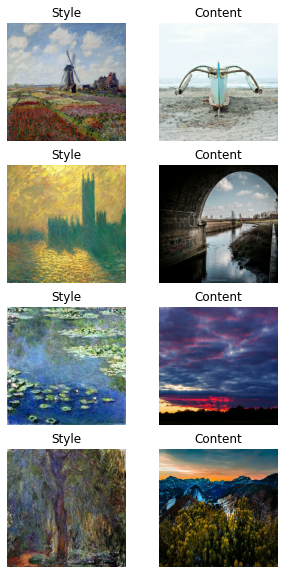

In [8]:
idx = np.random.choice(len(monet_tr)-4)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(5, 10))
[ax.axis("off") for ax in np.ravel(axes)]

for (ax_monet, ax_photo), monet_im, photo_im in zip(axes, monet_tr[idx:idx+4], photo_tr[idx:idx+4]):
    ax_monet.imshow(monet_im.numpy().astype("int"))
    ax_monet.set_title("Style")
    
    ax_photo.imshow(photo_im.numpy().astype("int"))
    ax_photo.set_title("Content")

# Adaptive Instance Normalization
The style transfer architecture can be broken down into the following individual blocks:
- Encoder: This is a pretrianed VGG19 model that encodes the content and stlye input image to a feature space.
- AdaIN: A layer that performs the adaptive instance normalization on the encoded content image.
- Decoder: This is the generator. This is responsible for building an image from the AdaIN output tensor.
- Loss Net: A pretrained VGG19 model.

## VGG19 Encoder

In [9]:
def get_mini_vgg():
    vgg19 = tf.keras.applications.VGG19(
        include_top=False,
        weights='imagenet'
    )
    vgg19.trainable = False
    mini_vgg19 = tf.keras.Model(vgg19.input, vgg19.get_layer("block4_conv1").output)
    
    inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3])
    preprocessed = tf.keras.applications.vgg19.preprocess_input(inputs)
    mini_vgg19_out = mini_vgg19(preprocessed)
    return tf.keras.Model(inputs, mini_vgg19_out, name="mini_vgg19")

def get_loss_net():
    vgg19 = tf.keras.applications.VGG19(
        include_top=False,
        weights='imagenet'
    )
    vgg19.trainable = False
    layer_names = [
        "block1_conv1",
        "block2_conv1",
        "block3_conv1",
        "block4_conv1"
    ]
    outputs = [vgg19.get_layer(name).output for name in layer_names]
    mini_vgg19 = tf.keras.Model(vgg19.input, outputs)
    
    inputs = tf.keras.layers.Input([*IMAGE_SIZE, 3])
    preprocessed = tf.keras.applications.vgg19.preprocess_input(inputs)
    mini_vgg19_out = mini_vgg19(preprocessed)
    return tf.keras.Model(inputs, mini_vgg19_out, name="loss_net")

## AdaIN Layer

In [10]:
# Reference: https://github.com/ftokarev/tf-adain
def ada_in(style, content, epsilon=1e-5):
    axes = [1,2]

    c_mean, c_var = tf.nn.moments(content, axes=axes, keepdims=True)
    s_mean, s_var = tf.nn.moments(style, axes=axes, keepdims=True)
    c_std, s_std = tf.sqrt(c_var + epsilon), tf.sqrt(s_var + epsilon)
    
    t = s_std * (content - c_mean) / c_std + s_mean
    return t

## Generator Block
This is the most important block in the whole architecture. This is the generator that takes AdaIN outputs and transforms them into synthetic stylised images.

In my implementation I have used the following pieces to build the decoder:
- Self Attention
- Conv Transpose layers
- Dropout
- Pixel Shuffle

In [11]:
def get_self_attention(input_shape, i):
    """
    A utility function to create a self_attention layer.

    Args:
        input_shape: The input shape to the layer. eg. (H, W, C)
        i: index number for naming
    """
    H,W,C = input_shape
    C_hat = C//8
    N = H*W

    Wq = tf.keras.layers.Conv2D(
        filters=C_hat,
        kernel_size=1
    )
    Wk = tf.keras.layers.Conv2D(
        filters=C_hat,
        kernel_size=1
    )
    Wv = tf.keras.layers.Conv2D(
        filters=C_hat,
        kernel_size=1
    )
    Wo = tf.keras.layers.Conv2D(
        filters=C,
        kernel_size=1
    )

    gamma = tf.Variable(0.0, name="gamma")

    inputs = tf.keras.layers.Input(shape=input_shape)

    query = Wq(inputs)
    query_flat = tf.keras.layers.Reshape((N,C_hat))(query)

    key = Wk(inputs)
    key_flat = tf.keras.layers.Reshape((N,C_hat))(key)
    
    similarity = tf.keras.layers.Multiply()([query_flat, key_flat])

    beta = tf.keras.layers.Softmax()(similarity)

    value = Wv(inputs)
    value_flat = tf.keras.layers.Reshape((N,C_hat))(value)
    
    context = tf.keras.layers.Multiply()([beta, value_flat])
    context = tf.keras.layers.Reshape((H,W,C_hat))(context)
    output = Wo(context)

    y = tf.keras.layers.Add()([gamma*output,inputs])

    model = tf.keras.Model(inputs=inputs, outputs=y, name=f"self_attention_block_{i}")
    return model

In [12]:
def get_upsample_block(filters, size, index):
    upsample_block = tf.keras.Sequential(name=f"upsampling_block_{index}")
    upsample_block.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same")
    )
    upsample_block.add(tf.keras.layers.PReLU())
    upsample_block.add(tf.keras.layers.Conv2D(filters, size, padding="same"))
    upsample_block.add(tf.keras.layers.PReLU())
    upsample_block.add(tf.keras.layers.Conv2D(filters, size, padding="same"))
    upsample_block.add(tf.keras.layers.PReLU())
    upsample_block.add(tf.keras.layers.Conv2D(filters, size, padding="same"))
    upsample_block.add(tf.keras.layers.PReLU())
    upsample_block.add(tf.keras.layers.Conv2D(filters, size, padding="same"))
    upsample_block.add(tf.keras.layers.PReLU())
    
    return upsample_block

def get_generator():
    inputs = tf.keras.layers.Input((32,32,512))
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same")(inputs)
    x = tf.keras.layers.PReLU()(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same")(x)
    x = tf.keras.layers.PReLU()(x)
    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, padding="same")(x)
    x = tf.keras.layers.PReLU()(x)
    
    self_attention = get_self_attention(x.shape.as_list()[1:], 1)
    x = self_attention(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = get_upsample_block(filters=256, size=3, index=2)(x)
    
    self_attention = get_self_attention(x.shape.as_list()[1:], 2)
    x = self_attention(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = get_upsample_block(filters=128, size=3, index=3)(x)
    
    self_attention = get_self_attention(x.shape.as_list()[1:], 3)
    x = self_attention(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same")(x)
    x = tf.keras.layers.PReLU()(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="same")(x)
    x = tf.keras.layers.PReLU()(x)
    
    self_attention = get_self_attention(x.shape.as_list()[1:], 4)
    x = self_attention(x)
    
    x = tf.keras.layers.Conv2D(filters=3 * (2 * 2), kernel_size=3, padding="same")(x)
    x = tf.nn.depth_to_space(x, 2, name="pixel_shuffle")
    
    x = tf.clip_by_value(x, 0., 255.)
    
    return tf.keras.Model(inputs=inputs, outputs=x, name="generator")

# Training

We create a CustomModel that helps us train the model using the `model.fit` API of keras.

In [13]:
def get_mean_std(tensor, epsilon=1e-5):
    tensor_mean, tensor_var = tf.nn.moments(tensor, axes=[1,2], keepdims=True)
    tensor_std = tf.sqrt(tensor_var + epsilon)
    return tensor_mean, tensor_std

In [19]:
class CustomModel(tf.keras.Model):
    def __init__(self, mini_vgg, loss_net, generator):
        super().__init__()
        self.mini_vgg = mini_vgg
        self.loss_net = loss_net
        self.generator = generator

    def compile(self, opt, loss_fn):
        super().compile()
        self.opt = opt
        self.loss_fn = loss_fn

    def train_step(self, data):
        style, content = data
    
        with tf.GradientTape() as tape:
            # encode the content and style
            style_enc = self.mini_vgg(style, training=False)
            content_enc = self.mini_vgg(content, training= False)
            
            # build the adain output
            t = ada_in(style_enc, content_enc)
            
            # generate the stylised image
            output_image = self.generator(t, training=True)
            output_vgg_loss = self.loss_net(output_image, training=False)
            style_vgg_loss = self.loss_net(style, training=False)
            
            # content loss
            loss_content = self.loss_fn(t,output_vgg_loss[-1])
            loss_content = tf.math.reduce_mean(loss_content, axis=[-1,-2])
            
            # style loss
            loss_style = 0
            for inp, out in zip(style_vgg_loss, output_vgg_loss):
                mean_inp, std_inp = get_mean_std(inp)
                mean_out, std_out = get_mean_std(out)
                
                loss_style += self.loss_fn(mean_inp, mean_out) + self.loss_fn(std_inp, std_out)
            
            loss_style = tf.math.reduce_mean(loss_style, axis=[-1,-2])
            total_loss = loss_content + 4.0 * loss_style
        
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.opt.apply_gradients(zip(gradients, trainable_vars))
        
        return {
            "total_loss": total_loss, 
            "content_loss": loss_content,
            "style_loss": 4.0 * loss_style,
        }

In [20]:
EPOCHS = 500
with strategy.scope():
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss_fn = tf.keras.losses.mean_squared_error
    
    mini_vgg = get_mini_vgg()
    loss_net = get_loss_net()
    generator = get_generator()
    
    model = CustomModel(
        mini_vgg = mini_vgg,
        loss_net = loss_net,
        generator = generator,
    )
    model.compile(
        opt = opt,
        loss_fn = loss_fn
    )
    
    history = model.fit(train_ds, epochs=EPOCHS)

Epoch 1/500
30/30 [==============================] - 42s 97ms/step - total_loss: 2353609.0000 - content_loss: 598211.9375 - style_loss: 1755397.3750
Epoch 2/500
30/30 [==============================] - 3s 95ms/step - total_loss: 1535887.7500 - content_loss: 566370.5000 - style_loss: 969517.1250
Epoch 3/500
30/30 [==============================] - 3s 96ms/step - total_loss: 1337983.0000 - content_loss: 531769.8125 - style_loss: 806213.2500
Epoch 4/500
30/30 [==============================] - 3s 95ms/step - total_loss: 1310851.3750 - content_loss: 531206.6875 - style_loss: 779644.5625
Epoch 5/500
30/30 [==============================] - 3s 96ms/step - total_loss: 1349639.7500 - content_loss: 569516.9375 - style_loss: 780122.6875
Epoch 6/500
30/30 [==============================] - 3s 96ms/step - total_loss: 1241039.0000 - content_loss: 544525.0625 - style_loss: 696513.8125
Epoch 7/500
30/30 [==============================] - 3s 96ms/step - total_loss: 1016093.4375 - content_loss: 499708.

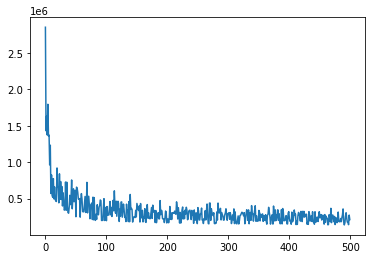

In [21]:
plt.plot(history.history['total_loss'])
plt.show()

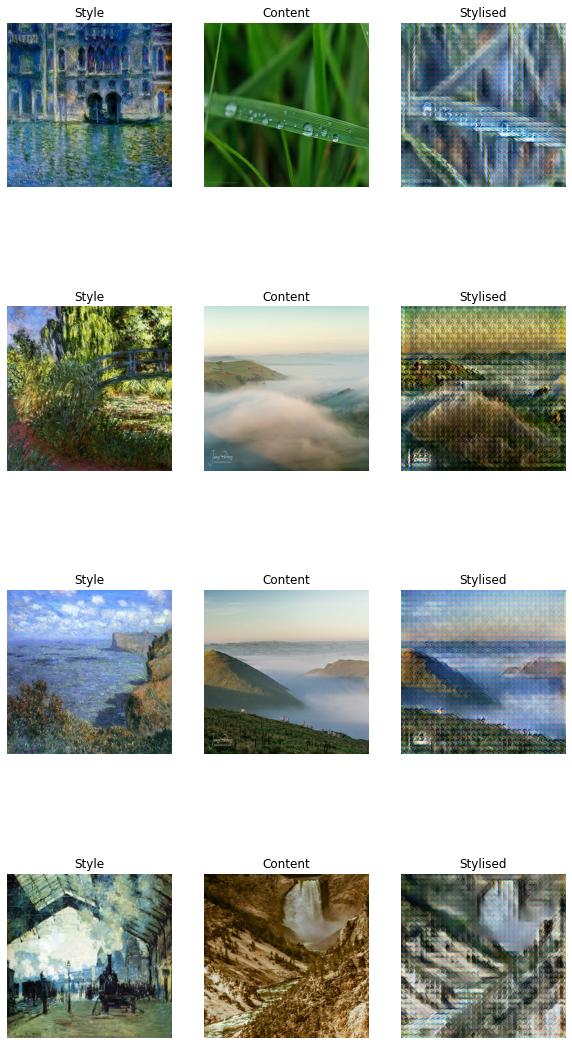

In [22]:
idx = np.random.choice(len(monet_tr)-4)
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(10, 20))
[ax.axis("off") for ax in np.ravel(axes)]

for (ax_style, ax_content, ax_out), style_im, content_im in zip(axes, monet_te[idx:idx+4], photo_te[idx:idx+4]):
    with strategy.scope():
        style_enc = model.mini_vgg(style_im[None, ...], training=False)
        content_enc = model.mini_vgg(content_im[None, ...], training=False)
        # build the adain output
        t = ada_in(style_enc, content_enc)  
        # generate the stylised image
        output_image = model.generator.predict(t)
    ax_style.imshow(style_im.numpy().squeeze().astype("int"))
    ax_style.set_title("Style")
    
    ax_content.imshow(content_im.numpy().squeeze().astype("int"))
    ax_content.set_title("Content")
    
    ax_out.imshow(output_image.squeeze().astype("int"))
    ax_out.set_title("Stylised")

# Conclusion

We can see here that the content of the images is retained while the color and the strokes of the style images finds its way into the stylised image. We can also notice the checkboard artifacts. One can use this notebook and work on the decoder to mitigate the problem furter.